# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Задача обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Необходимо построить модель со значением метрики качества *F1* не меньше 0.75. 

**План работы**

1. Загрузить и подготовить данные.
2. Обучить разные модели. 
3. Сделать выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`.  
Столбец *'text'* в нём содержит текст комментария.  
Столбец *'toxic'* — целевой признак.

## Подготовка

### Загрузка и проверка данных

In [1]:
import pandas as pd
import numpy as np

try:
    import matplotlib.pyplot as plt
except:
    !pip install --upgrade matplotlib==3.8.4
    import matplotlib.pyplot as plt

try:
    import seaborn as sns
except:
    !pip install --upgrade seaborn==0.13

import re
import sys
try:
    import spacy
except:
    !pip install spacy
    import spacy

from tqdm import tqdm

from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords as nltk_stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

import time
import warnings
warnings.simplefilter("ignore")

In [2]:
# Загрузим данные
try:
    toxic_comments = pd.read_csv('/datasets/toxic_comments.csv', index_col=[0])
except:
    toxic_comments = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=[0])

display(toxic_comments.head())
print('-' * 40)
print(toxic_comments.info())

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


----------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB
None


Данные содержат 159292 наблюдения. В столбце `text` находятся тексты, в столбце `toxic` - целевой признак (разметка о токсичности текстов). Прежде всего проверим данные на наличие пропусков и дубликатов.

In [3]:
# Проверка на наличие пропусков
print(f'Количество пропущенных значений: \n{toxic_comments.isna().sum()}')

print('-' * 40)

# Проверка на наличие дубликатов
print(f'Количество дубликатов: {toxic_comments.duplicated().sum()}')

Количество пропущенных значений: 
text     0
toxic    0
dtype: int64
----------------------------------------
Количество дубликатов: 0


Пропусков и дубликатов в данных нет.  
Проверим распределение целевого признака.

In [4]:
# Проверим, какие значения в столбце с целевым признаком и их количество
toxic_comments['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

Токсичность - целевой признак, он находится в столбце `toxic`. Метка `токсично` обозначена как `1`, метка `не токсично` обозначена как `0`, то есть целевой признак бинарный. Изобразим распределение целевого признака графически.

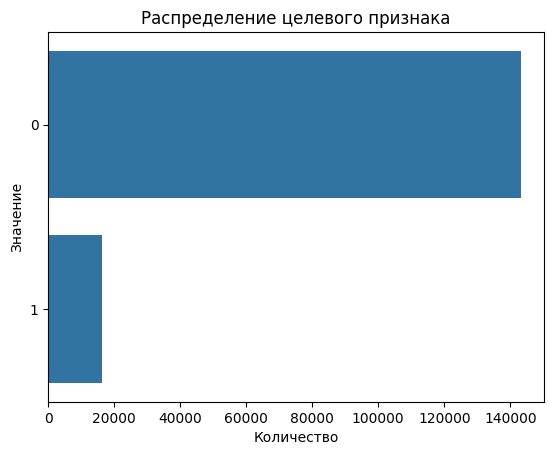

In [5]:
ax = sns.countplot(data=toxic_comments, y='toxic')
ax.set_title('Распределение целевого признака')
ax.set_xlabel('Количество')
ax.set_ylabel('Значение')
pass

In [6]:
toxic_comments.toxic.value_counts().max() / toxic_comments.toxic.value_counts().min()

8.841344371679229

Данные, как видно на графике, несбалансированы. Значений `0` почти в 9 раз больше, чем значений `1`. На несбалансированных данных модели будут плохо предсказывать минорный класс. Чтобы модели работали адекватно, нужно решить проблему дисбаланса классов. Для этого, во-первых, при разделении выборок на тренировочную и тестовую необходимо использовать стратификацию, а во-вторых, надо либо выполнить сэмплирование тренировочной выборки, либо при инициализации моделей указать, что данные несбалансированы.  
Но сначала выполним очистку и лемматизацию текстов.  
Работаем с датасетом, в котором 159292 строки и 2 столбца.

### Очистка и лемматизация

In [7]:
# Создадим класс для лемматизации SpaCy
nlp = spacy.load("en_core_web_sm")

In [8]:
# Создадим функцию для очистки и лемматизации
def prepare(text):
    clean = nlp(" ".join(re.sub(r'[^a-zA-z]', ' ', text).split()))
    text_lem = ' '.join([w.lemma_ for w in clean])
    return text_lem

In [9]:
# Проверим корректность работы функции
sentence1 = "The striped bats are hanging on their feet for best"
sentence2 = "you should be ashamed of yourself went worked"
df_my = pd.DataFrame([sentence1, sentence2], columns = ['text'])

print(df_my)
print()
print(df_my['text'].apply(prepare))

                                                text
0  The striped bats are hanging on their feet for...
1      you should be ashamed of yourself went worked

0    the stripe bat be hang on their foot for good
1        you should be ashamed of yourself go work
Name: text, dtype: object


Добавим в наш датафрейм `toxic_comments` столбец с лемматизированным текстом. Поскольку процесс лемматизации каждого токена длительный, для контроля времени лемматизации применим индикатор прогресса `progress_apply`.

In [10]:
tqdm.pandas()

toxic_comments['lemm_text'] = toxic_comments['text'].progress_apply(prepare)
toxic_comments.head()

100%|██████████████████████████████████████████████████████████████████████████| 159292/159292 [30:23<00:00, 87.37it/s]


,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation why the edit make under my usernam...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour I m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man I m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...


### Разделение признаков

In [11]:
# Зададим константу
RANDOM_STATE = 42

# Выделим признаки и таргет
features = toxic_comments.drop(['toxic'], axis = 1)
target = toxic_comments['toxic']

# Выделим тренировочную и валидационно-тестовую выборки
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features,
    target,
    test_size=0.3,
    random_state=RANDOM_STATE,
    stratify=target
)

# Выделим валидационную и тестовую выборки
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test,
    target_valid_test,
    test_size=0.5,
    random_state=RANDOM_STATE,
    stratify=target_valid_test
)

# Проверим размеры выборок
print(features_train.shape)
print(target_train.shape)
print()

print(features_valid.shape)
print(target_valid.shape)
print()

print(features_test.shape)
print(target_test.shape)

(111504, 2)
(111504,)

(23894, 2)
(23894,)

(23894, 2)
(23894,)


### Сэмплирование

Для борьбы с дисбалансом классов выполним андерсэмплинг, так как количество данных позволяет это сделать. Сэмплируем только тренировочные выборки.

In [12]:
# проверка баланса данных в исходном датасете
print(f'Тренировочные данные до сэмплирования:\n{target_train.value_counts()}')

# Вычисляем размер дисбаланса: узнаем, насколько данных мажорного класса больше
delta = target_train.value_counts().max() - target_train.value_counts().min()

# Отбираем случайные объекты мажорного класса для удаления
deleted_index = target_train.loc[target_train == 0].sample(delta).index

# удаляем наблюдения мажорного класса и сохраняем итоговые выборки
features_train_sampled = features_train[~features_train.index.isin(deleted_index)]
target_train_sampled = target_train[~target_train.index.isin(deleted_index)]

# проверка баланса данных в сэмплированном датасете
print(f'\nТренировочные данные после сэмплирования:\n{target_train_sampled.value_counts()}') 

Тренировочные данные до сэмплирования:
0    100174
1     11330
Name: toxic, dtype: int64

Тренировочные данные после сэмплирования:
0    11330
1    11330
Name: toxic, dtype: int64


In [13]:
# Итоговый размер тренировочных выборок
print(features_train_sampled.shape)
print(target_train_sampled.shape)

(22660, 2)
(22660,)


### Создание признаков

Теперь тренировочные данные сбалансированы. Создаём признаки для обучения.
Один вариант набора признаков создадим на сэмплированных данных.

In [14]:
# Загрузим список стоп-слов, создадим список английских стоп-слов
nltk.download('stopwords')
stopwords = nltk_stopwords.words('english')

# Создаём счётчик, указав в нём стоп-слова
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\olga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
# Создаём корпусы текстов
corpus_train = features_train_sampled['lemm_text']
corpus_valid = features_valid['lemm_text']
corpus_test = features_test['lemm_text']

In [16]:
# Получаем признаки в векторном представлении
tf_idf_train = count_tf_idf.fit_transform(corpus_train)
tf_idf_valid = count_tf_idf.transform(corpus_valid)
tf_idf_test = count_tf_idf.transform(corpus_test)

# Проверим размеры тренировочных выборок в векторном виде
print(tf_idf_train.shape)
print(tf_idf_valid.shape)
print(tf_idf_test.shape)

(22660, 44784)
(23894, 44784)
(23894, 44784)


Кроме того, существует возможность не применять сэмплирование, а при инициализации некоторых моделей можно указывать, что классы нужно сбалансировать. Поэтому подготовим второй вариант данных, без сэмплирования.

In [17]:
# Проверим размеры выборок
print(features_train.shape)
print(target_train.shape)
print()

print(features_valid.shape)
print(target_valid.shape)
print()

print(features_test.shape)
print(target_test.shape)

(111504, 2)
(111504,)

(23894, 2)
(23894,)

(23894, 2)
(23894,)


In [18]:
# Создаём корпусы текстов (без сэмплирования)
corpus_train_ns = features_train['lemm_text']
corpus_valid_ns = features_valid['lemm_text']
corpus_test_ns = features_test['lemm_text']

# Получаем признаки в векторном представлении (без сэмплирования)
tf_idf_train_ns = count_tf_idf.fit_transform(corpus_train_ns)
tf_idf_valid_ns = count_tf_idf.transform(corpus_valid_ns)
tf_idf_test_ns = count_tf_idf.transform(corpus_test_ns)

# Проверим размеры тренировочных выборок в векторном виде
print(tf_idf_train_ns.shape)
print(tf_idf_valid_ns.shape)
print(tf_idf_test_ns.shape)

(111504, 129478)
(23894, 129478)
(23894, 129478)


Итак, данные загружены, проверены на наличие пропусков и дубликатов. Тексты очищены и лемматизированы. Данные разделены на тренировочную, валидационную и тестовую выборки. Выявлен дисбаланс классов целевого признака, проблема дисбаланса решена с помощью андерсэмплинга. Загружен список стоп-слов, созданы мешки слов, исключив стоп-слова.  

Кроме того, подготовлены выборки для обучения моделей без сэмплирования.

Для обучения и тестирования моделей наши сэмплированные данные разделены на выборки: тренировочные `tf_idf_train` и `target_train_sampled`, валидационные `tf_idf_valid` и `target_valid`, тестовые `tf_idf_test` и `target_test`.  
Кроме того, готов второй вариант данных без сэмплирования: тренировочные `tf_idf_train_ns` и `target_train`, валидационные `tf_idf_valid_ns` и `target_valid`, тестовые `tf_idf_test_ns` и `target_test`.  

Гиперпараметры будем подбирать вручную.

## Обучение

При обучении разных моделей будем засекать время их обучения для дальнейшего их сравнения между собой. Если у моделей будет одинаковое качество предсказания, выбирать будем ту, которая обучается быстрее.

### Логистическая регрессия

In [19]:
# Напишем формулу для обучения моделей

def learning_model(model_name, model, X_train, X_valid, y_train, y_valid):

    # запускаем таймер
    start = time.time()
    
    # обучаем модель
    model.fit(X_train, y_train)
    
    # предсказания для X_valid
    pred = model.predict(X_valid)
    
    # получаем значения метрики F1 для модели
    f1 = round(f1_score(y_valid, pred), 2)

    # останавливаем таймер
    learn_time = round(time.time() - start, 3)
    
    # выводим на экран метрику F1
    print(f'Метрика F1 модели {model_name} получена: {f1}')

    # выводим на экран время обучения модели
    print(f'Время обучения модели {model_name} составило: {learn_time} с')
    
    # результат работы модели
    return f1, learn_time

In [20]:
# Инициализация и обучение модели логистической регрессии с гиперпараметрами по умолчанию
model_name_lr = "LR"
model_lr = LogisticRegression(random_state=RANDOM_STATE)



f1_lr, learn_time_lr = learning_model(model_name_lr,
                                      model_lr,
                                      tf_idf_train,
                                      tf_idf_valid,
                                      target_train_sampled,
                                      target_valid)

Метрика F1 модели LR получена: 0.68
Время обучения модели LR составило: 0.212 с


In [21]:
# Попробуем подобрать гиперпараметры для модели логистической регрессии
# Инициализация и обучение модели с новыми гиперпараметрами (вариант 1)
model_name_lr_1 = "LR, penalty='l1', C=0.5"
model_lr_1 = LogisticRegression(penalty='l1',
                                solver='saga',
                                C=0.5,
                                random_state=RANDOM_STATE)

f1_lr_1, learn_time_lr_1 = learning_model(model_name_lr_1,
                                          model_lr_1,
                                          tf_idf_train,
                                          tf_idf_valid,
                                          target_train_sampled,
                                          target_valid)

Метрика F1 модели LR, penalty='l1', C=0.5 получена: 0.72
Время обучения модели LR, penalty='l1', C=0.5 составило: 1.169 с


In [22]:
# Инициализация и обучение модели с новыми гиперпараметрами (вариант 2)
model_name_lr_2 = "LR, penalty='l1', C=5"
model_lr_2 = LogisticRegression(penalty='l1',
                                solver='saga',
                                C=5,
                                random_state=RANDOM_STATE)

f1_lr_2, learn_time_lr_2 = learning_model(model_name_lr_2,
                                          model_lr_2,
                                          tf_idf_train,
                                          tf_idf_valid,
                                          target_train_sampled,
                                          target_valid)

Метрика F1 модели LR, penalty='l1', C=5 получена: 0.7
Время обучения модели LR, penalty='l1', C=5 составило: 23.128 с


In [23]:
# Инициализация и обучение модели с новыми гиперпараметрами (вариант 3)
model_name_lr_3 = "LR, penalty='elasticnet', C=8"
model_lr_3 = LogisticRegression(penalty='elasticnet',
                                solver='saga',
                                l1_ratio=0.8,
                                C=8,
                                random_state=RANDOM_STATE)

f1_lr_3, learn_time_lr_3 = learning_model(model_name_lr_3,
                                          model_lr_3,
                                          tf_idf_train,
                                          tf_idf_valid,
                                          target_train_sampled,
                                          target_valid)

Метрика F1 модели LR, penalty='elasticnet', C=8 получена: 0.69
Время обучения модели LR, penalty='elasticnet', C=8 составило: 60.131 с


Рассмотрим вариант без сэмплирования, указав в настройках модели, что нужно обратить внимание на несбалансированность классов.

In [24]:
# Инициализация и обучение модели логистической регрессии без сэмплирования с гиперпараметрами по умолчанию
model_name_lr_ns = "LR_ns"
model_lr_ns = LogisticRegression(class_weight='balanced',
                                 random_state=RANDOM_STATE)

f1_lr_ns, learn_time_lr_ns = learning_model(model_name_lr_ns,
                                            model_lr_ns,
                                            tf_idf_train_ns,
                                            tf_idf_valid_ns,
                                            target_train,
                                            target_valid)

Метрика F1 модели LR_ns получена: 0.75
Время обучения модели LR_ns составило: 0.94 с


In [25]:
# Инициализация и обучение модели без сэмплирования с новыми гиперпараметрами (вариант 1)
model_name_lr_ns_1 = "LR_ns, penalty='l1', C=0.5"
model_lr_ns_1 = LogisticRegression(penalty='l1',
                                   solver='saga',
                                   C=0.5,
                                   class_weight='balanced',
                                   random_state=RANDOM_STATE)

f1_lr_ns_1, learn_time_lr_ns_1 = learning_model(model_name_lr_ns_1,
                                                model_lr_ns_1,
                                                tf_idf_train_ns,
                                                tf_idf_valid_ns,
                                                target_train,
                                                target_valid)

Метрика F1 модели LR_ns, penalty='l1', C=0.5 получена: 0.7
Время обучения модели LR_ns, penalty='l1', C=0.5 составило: 52.444 с


In [26]:
# Инициализация и обучение модели без сэмплирования с новыми гиперпараметрами (вариант 2)
model_name_lr_ns_2 = "LR_ns, penalty='l2', C=10"
model_lr_ns_2 = LogisticRegression(C=10,
                                   class_weight='balanced',
                                   random_state=RANDOM_STATE)

f1_lr_ns_2, learn_time_lr_ns_2 = learning_model(model_name_lr_ns_2,
                                                model_lr_ns_2,
                                                tf_idf_train_ns,
                                                tf_idf_valid_ns,
                                                target_train,
                                                target_valid)

Метрика F1 модели LR_ns, penalty='l2', C=10 получена: 0.75
Время обучения модели LR_ns, penalty='l2', C=10 составило: 1.277 с


In [27]:
# Инициализация и обучение модели без сэмплирования с новыми гиперпараметрами (вариант 3)
model_name_lr_ns_3 = "LR_ns, penalty='l1', C=10"
model_lr_ns_3 = LogisticRegression(penalty='l1',
                                   solver='saga',
                                   C=10,
                                   class_weight='balanced',
                                   random_state=RANDOM_STATE)

f1_lr_ns_3, learn_time_lr_ns_3 = learning_model(model_name_lr_ns_3,
                                                model_lr_ns_3,
                                                tf_idf_train_ns,
                                                tf_idf_valid_ns,
                                                target_train,
                                                target_valid)

Метрика F1 модели LR_ns, penalty='l1', C=10 получена: 0.72
Время обучения модели LR_ns, penalty='l1', C=10 составило: 364.292 с


In [28]:
results_lr = {
    'model': [model_name_lr,
              model_name_lr_1,
              model_name_lr_2,
              model_name_lr_3,
              model_name_lr_ns,
              model_name_lr_ns_1,
              model_name_lr_ns_2,
              model_name_lr_ns_3],
    'F1': [f1_lr, f1_lr_1, f1_lr_2, f1_lr_3, f1_lr_ns, f1_lr_ns_1, f1_lr_ns_2, f1_lr_ns_3],
    'learn_time': [learn_time_lr,
                   learn_time_lr_1,
                   learn_time_lr_2,
                   learn_time_lr_3,
                   learn_time_lr_ns,
                   learn_time_lr_ns_1,
                   learn_time_lr_ns_2,
                   learn_time_lr_ns_3]
}

def model_results(results):
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by=['F1', 'learn_time'], ascending=[False, True]).reset_index(drop=True)
    return results_df

result_lr = model_results(results_lr)
result_lr

,model,F1,learn_time
0,LR_ns,0.75,0.940
1,"LR_ns, penalty='l2', C=10",0.75,1.277
2,"LR, penalty='l1', C=0.5",0.72,1.169
3,"LR_ns, penalty='l1', C=10",0.72,364.292
4,"LR, penalty='l1', C=5",0.70,23.128
5,"LR_ns, penalty='l1', C=0.5",0.70,52.444
6,"LR, penalty='elasticnet', C=8",0.69,60.131
7,LR,0.68,0.212


Модель логистической регрессии лучше всего отработала на несэмплированных данных с гиперпараметрами по умолчанию и с гиперпараметрами `penalty='l2'`, `C=10`. Значение метрики `F1` у таких моделей составило 0,75. Но время обучения у модели с гиперпараметрами по умолчанию меньше, менее 1 секунды, то есть эта модель предпочтительнее.

### Модель дерева решений

In [29]:
# С гиперпараметрами по умолчанию
model_name_dtc = "DTC"
model_dtc = DecisionTreeClassifier(random_state=RANDOM_STATE)

f1_dtc, learn_time_dtc = learning_model(model_name_dtc,
                                        model_dtc,
                                        tf_idf_train,
                                        tf_idf_valid,
                                        target_train_sampled,
                                        target_valid)

Метрика F1 модели DTC получена: 0.54
Время обучения модели DTC составило: 12.841 с


In [30]:
# С изменёнными гиперпараметрами (вариант 1)
model_name_dtc_1 = "DTC, max_depth=4, min_samples_split=2, min_samples_leaf=3, max_leaf_nodes=50"
model_dtc_1 = DecisionTreeClassifier(max_depth=4,
                                     min_samples_split=2,
                                     min_samples_leaf=3,
                                     max_leaf_nodes=50,
                                     random_state=RANDOM_STATE)

f1_dtc_1, learn_time_dtc_1 = learning_model(model_name_dtc_1,
                                            model_dtc_1,
                                            tf_idf_train,
                                            tf_idf_valid,
                                            target_train_sampled,
                                            target_valid)

Метрика F1 модели DTC, max_depth=4, min_samples_split=2, min_samples_leaf=3, max_leaf_nodes=50 получена: 0.44
Время обучения модели DTC, max_depth=4, min_samples_split=2, min_samples_leaf=3, max_leaf_nodes=50 составило: 0.484 с


In [31]:
# С изменёнными гиперпараметрами (вариант 2)
model_name_dtc_2 = "DTC, max_depth=6"
model_dtc_2 = DecisionTreeClassifier(max_depth=6,
                                     random_state=RANDOM_STATE)

f1_dtc_2, learn_time_dtc_2 = learning_model(model_name_dtc_2,
                                            model_dtc_2,
                                            tf_idf_train,
                                            tf_idf_valid,
                                            target_train_sampled,
                                            target_valid)

Метрика F1 модели DTC, max_depth=6 получена: 0.48
Время обучения модели DTC, max_depth=6 составило: 0.665 с


In [32]:
# С изменёнными гиперпараметрами (вариант 3)
model_name_dtc_3 = "DTC, max_depth=8"
model_dtc_3 = DecisionTreeClassifier(max_depth=8,
                                     random_state=RANDOM_STATE)

f1_dtc_3, learn_time_dtc_3 = learning_model(model_name_dtc_3,
                                            model_dtc_3,
                                            tf_idf_train,
                                            tf_idf_valid,
                                            target_train_sampled,
                                            target_valid)

Метрика F1 модели DTC, max_depth=8 получена: 0.54
Время обучения модели DTC, max_depth=8 составило: 0.823 с


In [33]:
# Без сэмплирования с гиперпараметрами по умолчанию
model_name_dtc_ns = "DTC_ns"
model_dtc_ns = DecisionTreeClassifier(random_state=RANDOM_STATE)

f1_dtc_ns, learn_time_dtc_ns = learning_model(model_name_dtc_ns,
                                              model_dtc_ns,
                                              tf_idf_train_ns,
                                              tf_idf_valid_ns,
                                              target_train,
                                              target_valid)

Метрика F1 модели DTC_ns получена: 0.71
Время обучения модели DTC_ns составило: 317.664 с


In [34]:
# Без сэмплирования с новыми гиперпараметрами
model_name_dtc_ns_1 = "DTC_ns, max_depth=8"
model_dtc_ns_1 = DecisionTreeClassifier(max_depth=8, random_state=RANDOM_STATE)

f1_dtc_ns_1, learn_time_dtc_ns_1 = learning_model(model_name_dtc_ns_1,
                                                  model_dtc_ns_1,
                                                  tf_idf_train_ns,
                                                  tf_idf_valid_ns,
                                                  target_train,
                                                  target_valid)

Метрика F1 модели DTC_ns, max_depth=8 получена: 0.58
Время обучения модели DTC_ns, max_depth=8 составило: 4.253 с


In [35]:
results_dtc = {
    'model': [model_name_dtc,
              model_name_dtc_1,
              model_name_dtc_2,
              model_name_dtc_3,
              model_name_dtc_ns,
              model_name_dtc_ns_1
             ],
    'F1': [f1_dtc, f1_dtc_1, f1_dtc_2, f1_dtc_3, f1_dtc_ns, f1_dtc_ns_1],
    'learn_time': [learn_time_dtc,
                   learn_time_dtc_1,
                   learn_time_dtc_2,
                   learn_time_dtc_3,
                   learn_time_dtc_ns,
                   learn_time_dtc_ns_1]
}

result_dtc = model_results(results_dtc)
result_dtc

,model,F1,learn_time
0,DTC_ns,0.71,317.664
1,"DTC_ns, max_depth=8",0.58,4.253
2,"DTC, max_depth=8",0.54,0.823
3,DTC,0.54,12.841
4,"DTC, max_depth=6",0.48,0.665
5,"DTC, max_depth=4, min_samples_split=2, min_sam...",0.44,0.484


Дерево решений отработало лучше всего на несэмплированных данных с гиперпараметрами по умолчанию, значение метрики `F1` составило 0,71. Время обучения этой модели более 5 минут.

### Модель случайного леса

In [36]:
# С гиперпараметрами по умолчанию
model_name_rfc = "RFC"
model_rfc = RandomForestClassifier(random_state=RANDOM_STATE)

f1_rfc, learn_time_rfc = learning_model(model_name_rfc,
                                        model_rfc,
                                        tf_idf_train,
                                        tf_idf_valid,
                                        target_train_sampled,
                                        target_valid)

Метрика F1 модели RFC получена: 0.66
Время обучения модели RFC составило: 71.059 с


In [37]:
# С новыми гиперпараметрами (вариант 1)
model_name_rfc_1 = "RFC, n_estimators=200, max_depth=30"
model_rfc_1 = RandomForestClassifier(n_estimators = 200,
                                     max_depth=30,
                                     random_state=RANDOM_STATE)

f1_rfc_1, learn_time_rfc_1 = learning_model(model_name_rfc_1,
                                            model_rfc_1,
                                            tf_idf_train,
                                            tf_idf_valid,
                                            target_train_sampled,
                                            target_valid)

Метрика F1 модели RFC, n_estimators=200, max_depth=30 получена: 0.45
Время обучения модели RFC, n_estimators=200, max_depth=30 составило: 12.787 с


In [38]:
# С новыми гиперпараметрами (вариант 2)
model_name_rfc_2 = "RFC, n_estimators=300, max_depth=20"
model_rfc_2 = RandomForestClassifier(n_estimators = 300,
                                     max_depth=20,
                                     random_state=RANDOM_STATE)

f1_rfc_2, learn_time_rfc_2 = learning_model(model_name_rfc_2,
                                            model_rfc_2,
                                            tf_idf_train,
                                            tf_idf_valid,
                                            target_train_sampled,
                                            target_valid)

Метрика F1 модели RFC, n_estimators=300, max_depth=20 получена: 0.42
Время обучения модели RFC, n_estimators=300, max_depth=20 составило: 9.529 с


In [39]:
# Без сэмплирования с гиперпараметрами по умолчанию
model_name_rfc_ns = "RFC_ns"
model_rfc_ns = RandomForestClassifier(random_state=RANDOM_STATE)

f1_rfc_ns, learn_time_rfc_ns = learning_model(model_name_rfc_ns,
                                              model_rfc_ns,
                                              tf_idf_train_ns,
                                              tf_idf_valid_ns,
                                              target_train,
                                              target_valid)

Метрика F1 модели RFC_ns получена: 0.69
Время обучения модели RFC_ns составило: 507.956 с


In [40]:
results_rfc = {
    'model': [model_name_rfc,
              model_name_rfc_1,
              model_name_rfc_2,
              model_name_rfc_ns
             ],
    'F1': [f1_rfc, f1_rfc_1, f1_rfc_2, f1_rfc_ns],
    'learn_time': [learn_time_rfc,
                   learn_time_rfc_1,
                   learn_time_rfc_2,
                   learn_time_rfc_ns]
}

result_rfc = model_results(results_rfc)
result_rfc

,model,F1,learn_time
0,RFC_ns,0.69,507.956
1,RFC,0.66,71.059
2,"RFC, n_estimators=200, max_depth=30",0.45,12.787
3,"RFC, n_estimators=300, max_depth=20",0.42,9.529


Модель случайного леса лучше всего работает с гиперпараметрами по умолчанию на несэмплированных данных, метрика F1 принимает значение 0,69. Время обучения этой модели более 8 минут.

### Бустинговая модель LGBM

In [41]:
# С гиперпараметрами по умолчанию
model_name_lgbm = "LGBM"
model_lgbm = LGBMClassifier(random_state=RANDOM_STATE, verbose=-1)

f1_lgbm, learn_time_lgbm = learning_model(model_name_lgbm,
                                          model_lgbm,
                                          tf_idf_train,
                                          tf_idf_valid,
                                          target_train_sampled,
                                          target_valid)

Метрика F1 модели LGBM получена: 0.74
Время обучения модели LGBM составило: 3.557 с


In [42]:
# С изменёнными гиперпараметрами (вариант 1)
model_name_lgbm_1 = "LGBM, n_estimators=150, max_depth=2"
model_lgbm_1 = LGBMClassifier(n_estimators=150,
                              max_depth=2,
                              random_state=RANDOM_STATE,
                              verbose=-1)

f1_lgbm_1, learn_time_lgbm_1 = learning_model(model_name_lgbm_1,
                                              model_lgbm_1,
                                              tf_idf_train,
                                              tf_idf_valid,
                                              target_train_sampled,
                                              target_valid)

Метрика F1 модели LGBM, n_estimators=150, max_depth=2 получена: 0.7
Время обучения модели LGBM, n_estimators=150, max_depth=2 составило: 1.368 с


In [43]:
# С изменёнными гиперпараметрами (вариант 2)
model_name_lgbm_2 = "LGBM, n_estimators=200, max_depth=3, num_leaves=64"
model_lgbm_2 = LGBMClassifier(n_estimators=200,
                              max_depth=3,
                              num_leaves=25,
                              random_state=RANDOM_STATE)

f1_lgbm_2, learn_time_lgbm_2 = learning_model(model_name_lgbm_2,
                                              model_lgbm_2,
                                              tf_idf_train,
                                              tf_idf_valid,
                                              target_train_sampled,
                                              target_valid)

Метрика F1 модели LGBM, n_estimators=200, max_depth=3, num_leaves=64 получена: 0.72
Время обучения модели LGBM, n_estimators=200, max_depth=3, num_leaves=64 составило: 1.658 с


In [44]:
# С гиперпараметрами по умолчанию на несэмплированных данных
model_name_lgbm_ns = "LGBM_ns"
model_lgbm_ns = LGBMClassifier(class_weight='balanced', random_state=RANDOM_STATE)

f1_lgbm_ns, learn_time_lgbm_ns = learning_model(model_name_lgbm_ns,
                                                model_lgbm_ns,
                                                tf_idf_train_ns,
                                                tf_idf_valid_ns,
                                                target_train,
                                                target_valid)

Метрика F1 модели LGBM_ns получена: 0.75
Время обучения модели LGBM_ns составило: 18.45 с


In [45]:
# С изменёнными гиперпараметрами на несэмплированных данных
model_name_lgbm_ns_1 = "LGBM_ns, n_estimators=150, max_depth=2"
model_lgbm_ns_1 = LGBMClassifier(class_weight='balanced',
                                 n_estimators=150,
                                 max_depth=2,
                                 random_state=RANDOM_STATE)

f1_lgbm_ns_1, learn_time_lgbm_ns_1 = learning_model(model_name_lgbm_ns_1,
                                                    model_lgbm_ns_1,
                                                    tf_idf_train_ns,
                                                    tf_idf_valid_ns,
                                                    target_train,
                                                    target_valid)

Метрика F1 модели LGBM_ns, n_estimators=150, max_depth=2 получена: 0.7
Время обучения модели LGBM_ns, n_estimators=150, max_depth=2 составило: 10.374 с


In [46]:
results_lgbm = {
    'model': [model_name_lgbm,
              model_name_lgbm_1,
              model_name_lgbm_2,
              model_name_lgbm_ns,
              model_name_lgbm_ns_1],
    'F1': [f1_lgbm, f1_lgbm_1, f1_lgbm_2, f1_lgbm_ns, f1_lgbm_ns_1],
    'learn_time': [learn_time_lgbm,
                   learn_time_lgbm_1,
                   learn_time_lgbm_2,
                   learn_time_lgbm_ns,
                   learn_time_lgbm_ns_1]
}

result_lgbm = model_results(results_lgbm)
result_lgbm

,model,F1,learn_time
0,LGBM_ns,0.75,18.450
1,LGBM,0.74,3.557
2,"LGBM, n_estimators=200, max_depth=3, num_leave...",0.72,1.658
3,"LGBM, n_estimators=150, max_depth=2",0.70,1.368
4,"LGBM_ns, n_estimators=150, max_depth=2",0.70,10.374


Модель градиентного бустинга `LGBMClassifier()` показала лучший результат на несэмплированных данных, с гиперпараметрами по умолчанию. Метрика `F1` имеет значение 0,75. Модель обучается за 15,5 секунд.

### Бустинговая модель CatBoost

In [47]:
# Инициализация и обучение модели с гиперпараметрами по умолчанию
model_name_cbc = "CBC"
model_cbc = CatBoostClassifier(random_state=RANDOM_STATE, verbose=False)

f1_cbc, learn_time_cbc = learning_model(model_name_cbc,
                                        model_cbc,
                                        tf_idf_train,
                                        tf_idf_valid,
                                        target_train_sampled,
                                        target_valid)

Метрика F1 модели CBC получена: 0.74
Время обучения модели CBC составило: 315.382 с


In [48]:
# Инициализация и обучение модели с изменёнными гиперпараметрами (вариант 1)
model_name_cbc_1 = "CBC, depth=3"
model_cbc_1 = CatBoostClassifier(depth=3,
                                 random_state=RANDOM_STATE,
                                 verbose=False)

f1_cbc_1, learn_time_cbc_1 = learning_model(model_name_cbc_1,
                                            model_cbc_1,
                                            tf_idf_train,
                                            tf_idf_valid,
                                            target_train_sampled,
                                            target_valid)

Метрика F1 модели CBC, depth=3 получена: 0.74
Время обучения модели CBC, depth=3 составило: 112.782 с


In [49]:
# Инициализация и обучение модели с изменёнными гиперпараметрами (вариант 2)
model_name_cbc_2 = "CBC, depth=3, l2_leaf_reg=5"
model_cbc_2 = CatBoostClassifier(depth=3,
                                 l2_leaf_reg=5,
                                 random_state=RANDOM_STATE,
                                 verbose=False)

f1_cbc_2, learn_time_cbc_2 = learning_model(model_name_cbc_2,
                                            model_cbc_2,
                                            tf_idf_train,
                                            tf_idf_valid,
                                            target_train_sampled,
                                            target_valid)

Метрика F1 модели CBC, depth=3, l2_leaf_reg=5 получена: 0.73
Время обучения модели CBC, depth=3, l2_leaf_reg=5 составило: 114.536 с


In [50]:
# Инициализация и обучение модели с изменёнными гиперпараметрами (вариант 3)
model_name_cbc_3 = "CBC, iterations=500, depth=4"
model_cbc_3 = CatBoostClassifier(iterations=500,
                                 depth=4,
                                 random_state=RANDOM_STATE,
                                 verbose=False)

f1_cbc_3, learn_time_cbc_3 = learning_model(model_name_cbc_3,
                                            model_cbc_3,
                                            tf_idf_train,
                                            tf_idf_valid,
                                            target_train_sampled,
                                            target_valid)

Метрика F1 модели CBC, iterations=500, depth=4 получена: 0.74
Время обучения модели CBC, iterations=500, depth=4 составило: 77.417 с


In [51]:
# С гиперпараметрами по умолчанию на несэмплированных данных
model_name_cbc_ns = "CBC_ns"
model_cbc_ns = CatBoostClassifier(auto_class_weights='Balanced',
                                  random_state=RANDOM_STATE,
                                  verbose=False)

f1_cbc_ns, learn_time_cbc_ns = learning_model(model_name_cbc_ns,
                                              model_cbc_ns,
                                              tf_idf_train_ns,
                                              tf_idf_valid_ns,
                                              target_train,
                                              target_valid)

Метрика F1 модели CBC_ns получена: 0.75
Время обучения модели CBC_ns составило: 1022.58 с


In [52]:
# С изменёнными гиперпараметрами на несэмплированных данных
model_name_cbc_ns_1 = "CBC_ns, depth=3"
model_cbc_ns_1 = CatBoostClassifier(auto_class_weights='Balanced',
                                    depth=3,
                                    random_state=RANDOM_STATE,
                                    verbose=False)

f1_cbc_ns_1, learn_time_cbc_ns_1 = learning_model(model_name_cbc_ns_1,
                                                  model_cbc_ns_1,
                                                  tf_idf_train_ns,
                                                  tf_idf_valid_ns,
                                                  target_train,
                                                  target_valid)

Метрика F1 модели CBC_ns, depth=3 получена: 0.75
Время обучения модели CBC_ns, depth=3 составило: 399.982 с


In [53]:
results_cbc = {
    'model': [model_name_cbc,
              model_name_cbc_1,
              model_name_cbc_2,
              model_name_cbc_3,
              model_name_cbc_ns,
              model_name_cbc_ns_1],
    'F1': [f1_cbc, f1_cbc_1, f1_cbc_2, f1_cbc_3, f1_cbc_ns, f1_cbc_ns_1],
    'learn_time': [learn_time_cbc,
                   learn_time_cbc_1,
                   learn_time_cbc_2,
                   learn_time_cbc_3,
                   learn_time_cbc_ns,
                   learn_time_cbc_ns_1]
}

result_cbc = model_results(results_cbc)
result_cbc

,model,F1,learn_time
0,"CBC_ns, depth=3",0.75,399.982
1,CBC_ns,0.75,1022.580
2,"CBC, iterations=500, depth=4",0.74,77.417
3,"CBC, depth=3",0.74,112.782
4,CBC,0.74,315.382
5,"CBC, depth=3, l2_leaf_reg=5",0.73,114.536


Лучший результат показали две модели `CatBoost` на несэмплированных данных: с гиперпараметрами `depth=3`, то есть с ограничением глубины деревьев (время обучения составило более 6 минут), и с гиперпараметрами по умолчанию (время обучения более 17 минут). Метрика `F1` составила 0.75. 

## Выводы

In [54]:
# Соберём в одной таблице каждую модель с лучшими гиперпараметрами
result = (pd.concat(
    [result_lr[:1],
     result_dtc[:1],
     result_rfc[:1],
     result_lgbm[:1],
     result_cbc[:1]],
    axis=0
)).sort_values(by='F1', ascending=False).reset_index(drop=True)
result

,model,F1,learn_time
0,LR_ns,0.75,0.940
1,LGBM_ns,0.75,18.450
2,"CBC_ns, depth=3",0.75,399.982
3,DTC_ns,0.71,317.664
4,RFC_ns,0.69,507.956


Лучшие результаты у трёх моделей: логистической регрессии с гиперпараметрами по умолчанию на несэмплированных данных (время обучения менее 1 секунды), у бустинговой модели `LGBM` с гиперпараметрами по умолчанию на несэмплированных данных (время обучения 15.5 секунд) и бустинговой модели `CatBoost` с ограничением глубины деревьев `depth=3` на несэмплированных данных (время обучения более 17 секунд). Метрика `F1` составила 0.75. Рассчитаем метрику на тестовой выборке.

In [55]:
# Предсказания значений для X_test для модели логистической регрессии
pred_lr_ns_test = model_lr_ns.predict(tf_idf_test_ns)

# Получение значения метрики F1 для модели логистической регрессии
f1_lr_ns_test = round(f1_score(target_test, pred_lr_ns_test), 2)
print(f'Метрика F1 модели lr_ns на тестовых данных: {f1_lr_ns_test}')

Метрика F1 модели lr_ns на тестовых данных: 0.76


In [56]:
# Предсказания значений для X_test для модели `LGBM`
pred_lgbm_ns_test = model_lgbm_ns.predict(tf_idf_test_ns)

# Получение значения метрики F1 для модели `LGBM`
f1_lgbm_ns_test = round(f1_score(target_test, pred_lgbm_ns_test), 2)
print(f'Метрика F1 модели lgbm_ns на тестовых данных: {f1_lgbm_ns_test}')

Метрика F1 модели lgbm_ns на тестовых данных: 0.74


In [57]:
# Предсказания значений для X_test для модели `CatBoost`
pred_cbc_ns_1_test = model_cbc_ns_1.predict(tf_idf_test_ns)

# Получение значения метрики F1 для модели 'CatBoost'
f1_cbc_ns_1_test = round(f1_score(target_test, pred_cbc_ns_1_test), 2)
print(f'Метрика F1 модели cbc_ns_1 на тестовых данных: {f1_cbc_ns_1_test}')

Метрика F1 модели cbc_ns_1 на тестовых данных: 0.75


**Вывод.** Для классификации комментариев на позитивные и негативные интернет-магазину "Викишоп" следует использовать модель логистической регрессии с гиперпараметрами по умолчанию, которая лучше других показала себя при обучении и прогнозировании. Сэмплирование использовать не надо. В настройках модели нужно указать, что данные несбалансированы. На валидационных данных модель показала значение метрики `F1 = 0.75`, на тестовых данных - `F1 = 0.76`. Время обучения модели составило менее 1 секунды.